# Directional Semivariogram

In this tutorial, we will learn about directional semivariograms, how to set the angle of direction, and the tolerance parameter. We compare two neighbor selection methods: triangular, which is fast, and elliptical, which is accurate.

## Prerequisites

- **Domain**:
  - semivariance and covariance functions
- **Package**:
  - `TheoreticalVariogram`, `ExperimentalVariogram`
- **Programming**:
  - Python basics

## Table of contents

1. A directional process.
2. Create directional and isotropic semivariograms.
3. Compare directional semivariograms.
4. Compare triangular vs elliptical neighbors selection methods.

## 1. Directional process

Not every spatial process may be described by isotropic semivariograms. Sometimes we see a specific trend in one direction (N-S, W-E, or NE-SW, NW-SE). `Pyinterpolate` lets us model semivariance in a specific direction, or multiple directions with omnidirectional case. If you want to go straight to the code, then you should check API examples in notebooks (1) `tutorials/api-examples/a-1-2-directional-experimental-variogram` and (2) `tutorials/api-examples/a-1-4-directional-variogram-class`. This guide is more detailed, thus recommeded for users not familiar with the directional semivariogram concept.

> **Note**: if you are a machine learning enthusiast, then you can treat the direction as an additional feature to model semivariance.



## 2. Create directional and isotropic semivariograms

In [24]:
import geopandas as gpd
from pyinterpolate import ExperimentalVariogram, DirectionalVariogram

import matplotlib.pyplot as plt

In [2]:
VALUE_COL = 'PM2.5'
df = gpd.read_file('../data/air_pollution.gpkg', layer='pm2_5')
df.set_index('station_id', inplace=True)

In [3]:
df.head()

PM2.5                       geometry
station_id                                        
659         7.12765   POINT (720513.167 300494.94)
736         4.66432  POINT (475344.002 724090.975)
861         3.00739   POINT (526820.46 700473.261)
266         7.10000  POINT (748935.825 383022.087)
355         2.00000  POINT (529001.219 443458.908)

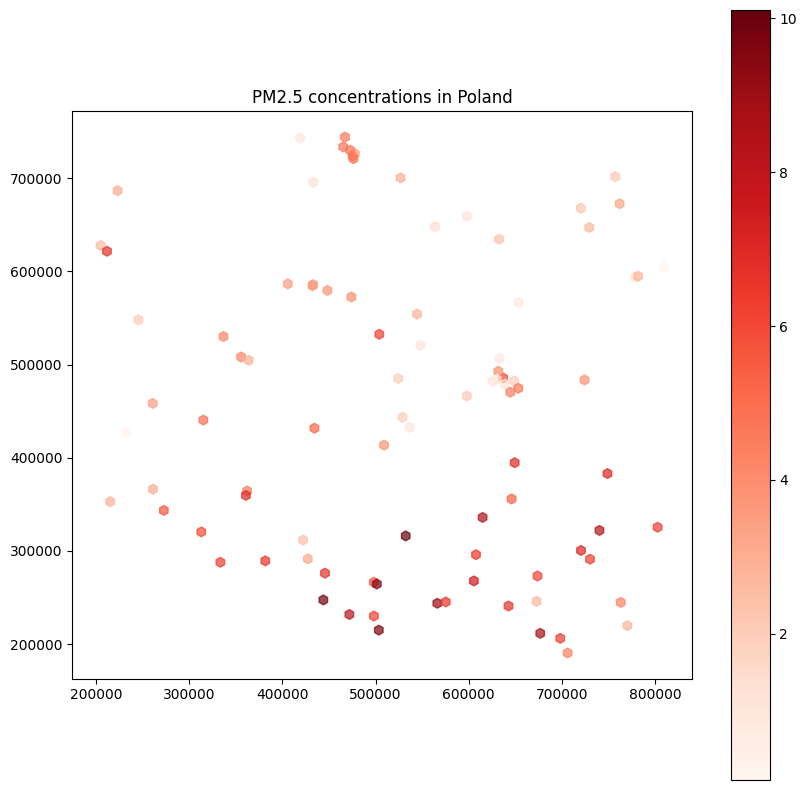

In [4]:
df.plot(figsize=(10, 10), column=VALUE_COL, legend=True, markersize=50, alpha=0.7, marker="h", cmap='Reds')
plt.title('PM2.5 concentrations in Poland')
plt.show()

### Including direction in experimental variogram

If we recall the first tutorial `1-1-semivariogram-exploration`, we set there three parameters:

1. `ds`: `numpy array` with coordinates and observed values, for example: `[[0, 0, 10], [0, 1, 20]]`,
2. `step_size`: we must divide our analysis area into discrete **lags**. **Lags** are intervals (usually circular) within which we check if the point has a neighbor. For example, if we look into the lag `500`, then we are going to compare one point with other points in a distance `(0, 1000]` from this point,
3. `max_range`: This parameter represents the possible **maximum range of spatial dependency**. This parameter should be at most half of the extent.

But that's not everything! We can use other parameters:

4. `direction`: it is a `float` in the range [0, 360]. We set the direction of the semivariogram:
  * 0 or 180: is WE direction,
  * 90 or 270 is NS direction,
  * 45 or 225 is NE-SW direction,
  * 135 or 315 is NW-SE direction.

5. `tolerance`: it is a `float` in the range [0, 1]. If we leave `tolerance` with default **1**, we will always get an isotropic semivariogram. Another edge case is if we set `tolerance` to **0**, then points must be placed on a single line with the beginning in the origin of the coordinate system and the angle given by the y-axis and direction parameter. If tolerance is > 0 and < 1, the bin is selected as an elliptical area with a major axis pointed in the same direction as the line for 0 tolerance.
  * The major axis size is `(tolerance * step_size)`,
  * The minor axis size is `((1 - tolerance) * step_size)`,
  * The baseline point is at the center of the ellipse.

6. `dir_neighbors_selection_method`: it is `str` with possible values:
  - `t` or `triangle` for triangular neighbors selection which is fast and recommended for a big dataset,
  - `e` or `ellipse` for elliptical neighbors selection which is accurate but slow, recommended for small-size datasets.

Those parameters are used to estimate semivariance and covariance in a leading direction. The `direction` and `tolerance` parameters might be better described with the picture:

<img src="images/dir_semi_tutorial_graphics.jpg" alt="The visualization of directional variogram calculation" style="max-width: 800px;"/>


* The top plane shows the black unit circle that represents the omnidirectional variogram. Within it, we see two ellipses: one is bright green and another is dark green.
* The bottom plane shows a unit circle and two ellipses: the brighter yellow, and darker purple.
* The long arrows within both circles are radii of the omnidirectional variogram or **the semi-major axis** of a directional ellipse. The `step_size` parameter controls its length. The shorter arrows are present only in the **directional variograms**. These represent the **semi-minor axes**. The `tolerance` parameter controls their length, and it is always:
 - a fraction of `step_size`,
 - **1**, in this case, a semivariogram is omnidirectional,
 - a value very close to 0 (but not 0) - then ellipse falls into line.
* The good idea is to set `tolerance` to 0.5 and gradually make it smaller or larger (depending on the spatial properties of a dataset).

---

We can start the analysis by understanding how our parameters affect the semivariogram bins range. We will set tolerance to 0.2 in each case to better visualize the effects of the leading direction.

### Case 1: West-East direction

In [10]:
SEMI_MAJOR_AXIS_SIZE = 40000  # meters
MAX_RANGE = 400000  # meters
TOLERANCE = 0.2
WE_DIRECTION = 0  # or 180

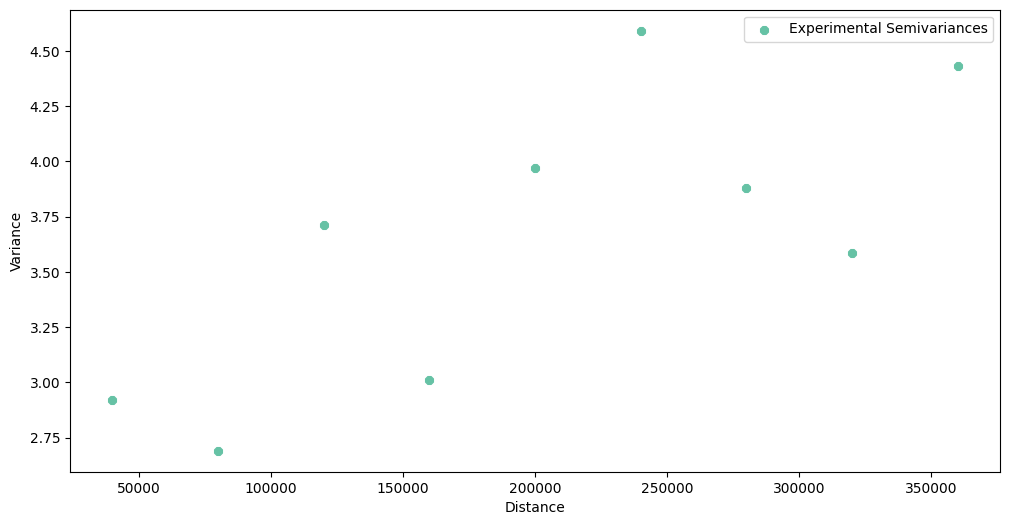

In [15]:
exp_var = ExperimentalVariogram(
    ds=df[['geometry', VALUE_COL]],
    step_size=SEMI_MAJOR_AXIS_SIZE,
    max_range=MAX_RANGE,
    direction=WE_DIRECTION,
    tolerance=TOLERANCE,
    dir_neighbors_selection_method='e'
)
exp_var.plot(semivariance=True, covariance=False, variance=False)

### Case 2: North-South direction

In [16]:
NS_DIRECTION = 90  # or 270

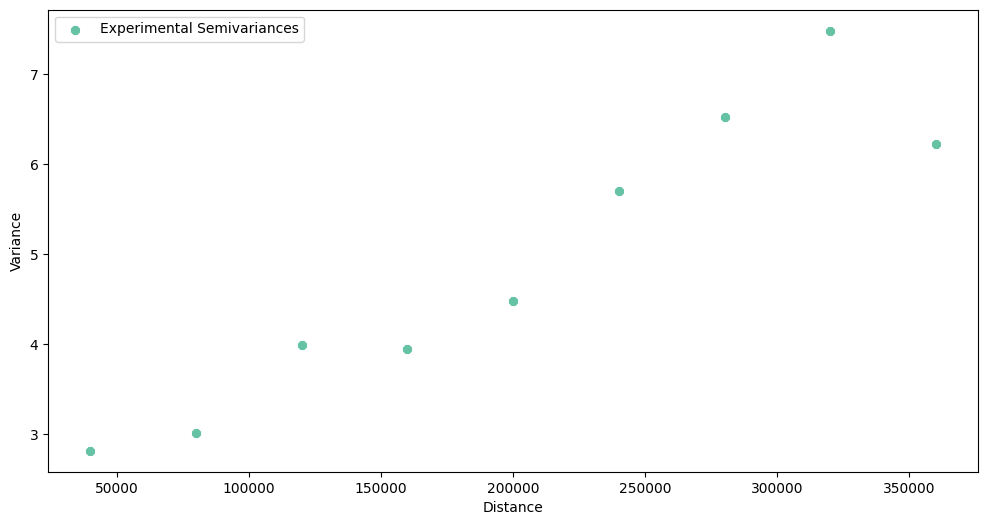

In [17]:
exp_var = ExperimentalVariogram(
    ds=df[['geometry', VALUE_COL]],
    step_size=SEMI_MAJOR_AXIS_SIZE,
    max_range=MAX_RANGE,
    direction=NS_DIRECTION,
    tolerance=TOLERANCE,
    dir_neighbors_selection_method='e'
)
exp_var.plot(semivariance=True, covariance=False, variance=False)

### Case 3: Northwest-Southeast direction

In [18]:
NW_SE_DIRECTION = 135  # or 315

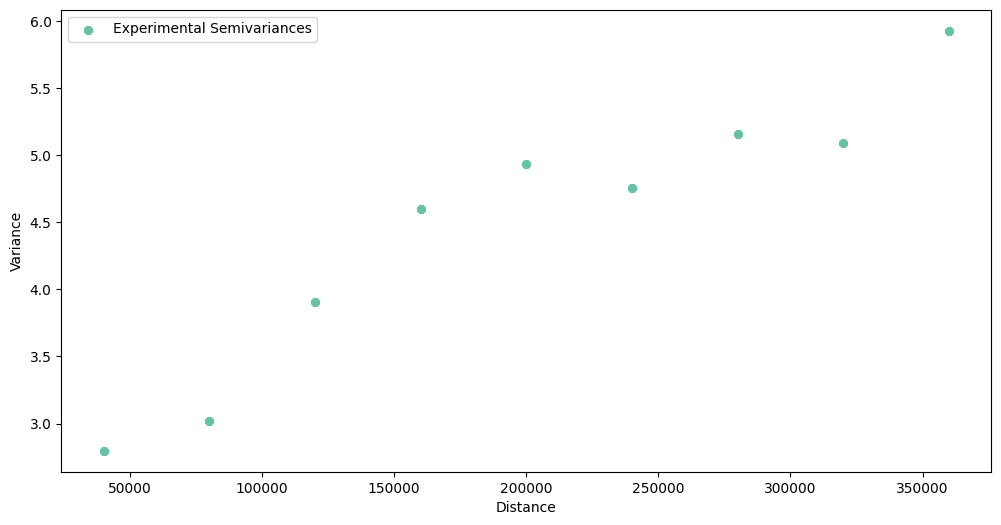

In [19]:
exp_var = ExperimentalVariogram(
    ds=df[['geometry', VALUE_COL]],
    step_size=SEMI_MAJOR_AXIS_SIZE,
    max_range=MAX_RANGE,
    direction=NW_SE_DIRECTION,
    tolerance=TOLERANCE,
    dir_neighbors_selection_method='e'
)
exp_var.plot(semivariance=True, covariance=False, variance=False)

### Case 4: Northeast-Southwest direction

In [20]:
NE_SW_DIRECTION = 45  # or 225

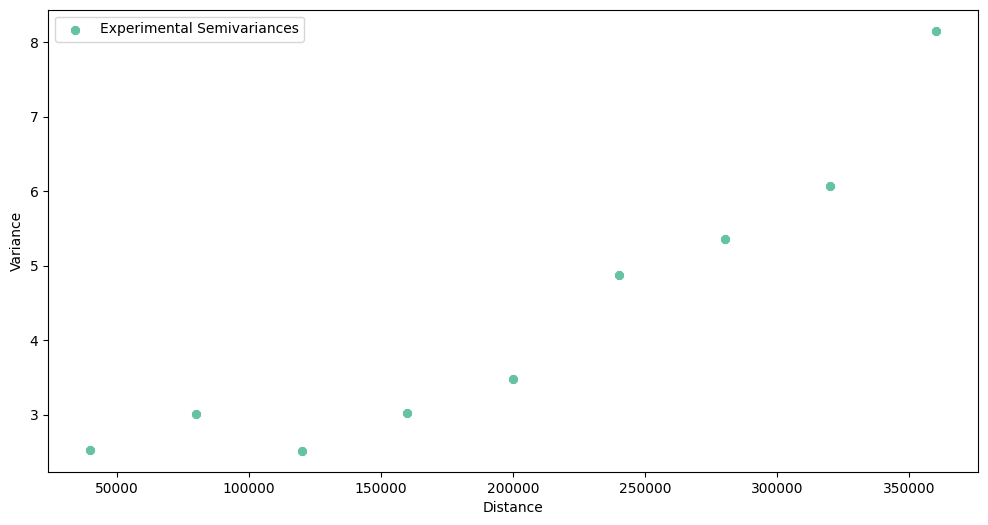

In [21]:
exp_var = ExperimentalVariogram(
    ds=df[['geometry', VALUE_COL]],
    step_size=SEMI_MAJOR_AXIS_SIZE,
    max_range=MAX_RANGE,
    direction=NE_SW_DIRECTION,
    tolerance=TOLERANCE,
    dir_neighbors_selection_method='e'
)
exp_var.plot(semivariance=True, covariance=False, variance=False)

### Case 5: Isotropic variogram - no leading direction

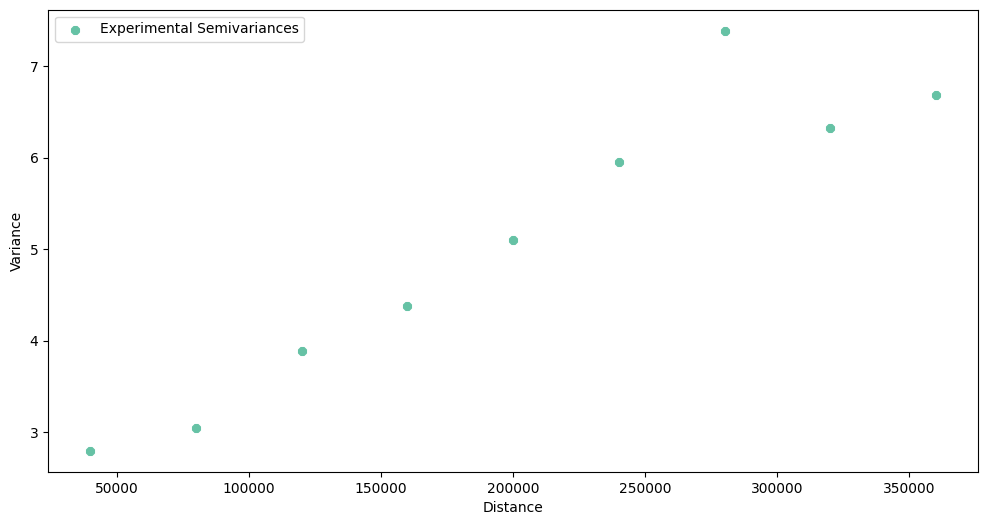

In [22]:
exp_var = ExperimentalVariogram(
    ds=df[['geometry', VALUE_COL]],
    step_size=SEMI_MAJOR_AXIS_SIZE,
    max_range=MAX_RANGE
)
exp_var.plot(semivariance=True, covariance=False, variance=False)

## 3. Compare semivariograms

We have created a set of variograms. What do we observe?

- The **NE-SW** variogram is very weak at describing a short-range variation (compare it to the map of air pollution from the beginning of the tutorial. Points in this direction are relatively similar).
- The **N-S** variogram works well for a short range.
- The **W-E** variogram catches too much variability, and lags must be longer for this direction.
- The **NW-SE** variogram looks good and shows approximately linear variability change in a distance function. It has the smallest variance from all variograms.

We can visualize and compare all variograms simultaneously, and we are sure that the y-axis is the same for every plot. We will use special class of `DirectionalVariogram` to calculate semivariances in all directions at once!

In [25]:
dir_var = DirectionalVariogram(
    ds=df[['geometry', VALUE_COL]],
    step_size=SEMI_MAJOR_AXIS_SIZE,
    max_range=MAX_RANGE,
    tolerance=TOLERANCE,
    dir_neighbors_selection_method='e'
)

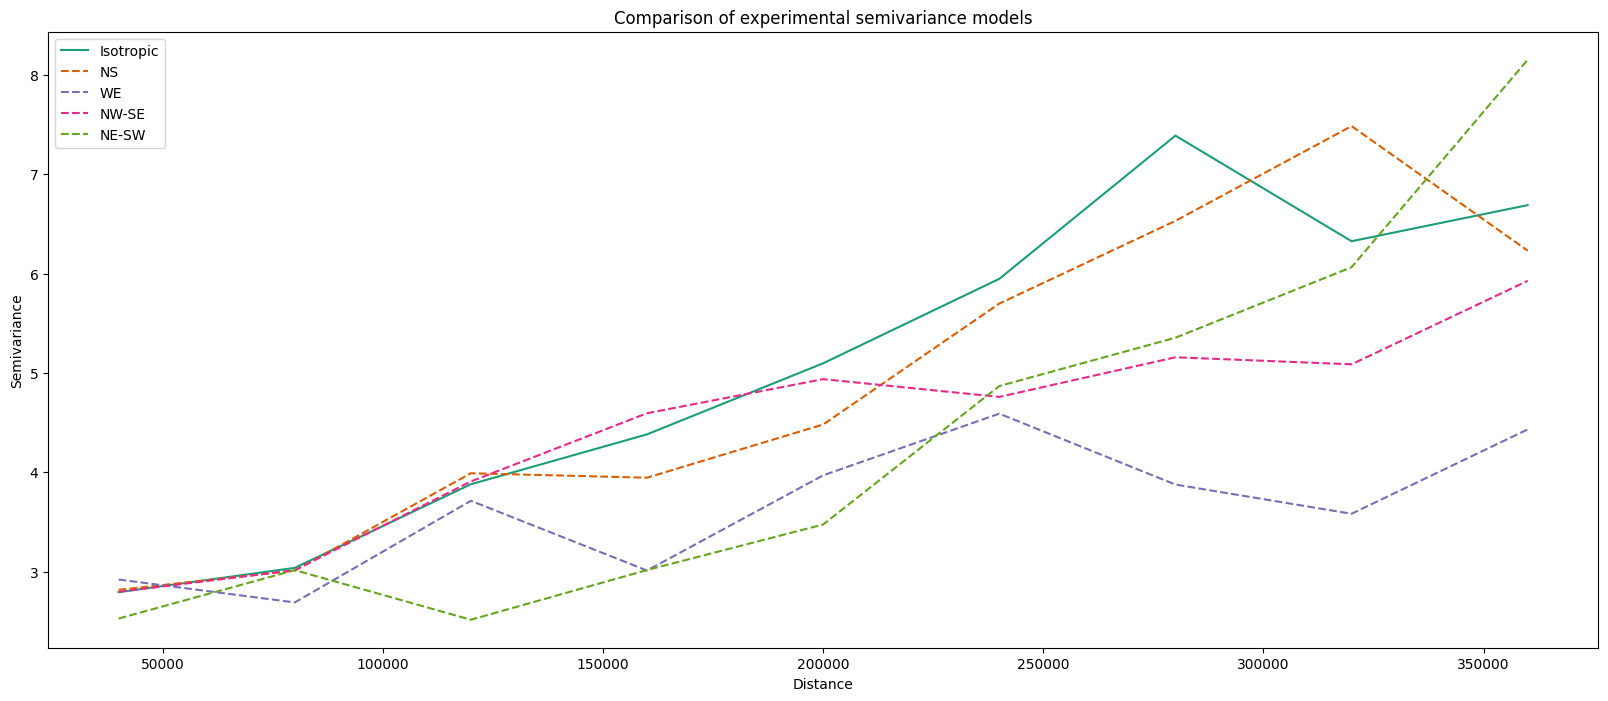

In [26]:
dir_var.show()

In your opinion, which semivariogram model is optimal? Should we pick isotropic (omnidirectional) variogram, or one of directional variograms? I'd check how variograms behave at a close distances - in this comparison **NE-SW** shouldn't be used. But any decision is not definitive, the best what we can do is to perform cross validation on different directional variograms and with different step sizes (bins width).

## 4. Compare triangular vs elliptical neighbors selection methods

Let's compare calculation times and results from two methods of neighbors interpolation: `t` (`triangular`) and `e` (`elliptical`). We will model two `DirectionalVariogram` objects and count how many seconds it takes, then we will compare output semivariograms.

In the previous release (0.x) `triangular` method was always faster. From the release 1.0 we recommend using elliptical selection, which is heavily optimized!

In [31]:
from time import perf_counter

In [32]:
t0e = perf_counter()
dir_var_e = DirectionalVariogram(
    ds=df[['geometry', VALUE_COL]],
    step_size=SEMI_MAJOR_AXIS_SIZE,
    max_range=MAX_RANGE,
    tolerance=TOLERANCE,
    dir_neighbors_selection_method='e'
)
txe = perf_counter()
print('Time of the semivariance calculations based on elliptical bins:')
print(txe - t0e)

Time of the semivariance calculations based on elliptical bins:
0.2028115200009779


In [33]:
t0t = perf_counter()
dir_var_t = DirectionalVariogram(
    ds=df[['geometry', VALUE_COL]],
    step_size=SEMI_MAJOR_AXIS_SIZE,
    max_range=MAX_RANGE,
    tolerance=TOLERANCE,
    dir_neighbors_selection_method='t'
)
txt = perf_counter()
print('Time of the semivariance calculations based on triangular bins:')
print(txt - t0t)

Time of the semivariance calculations based on triangular bins:
0.9874764849992061


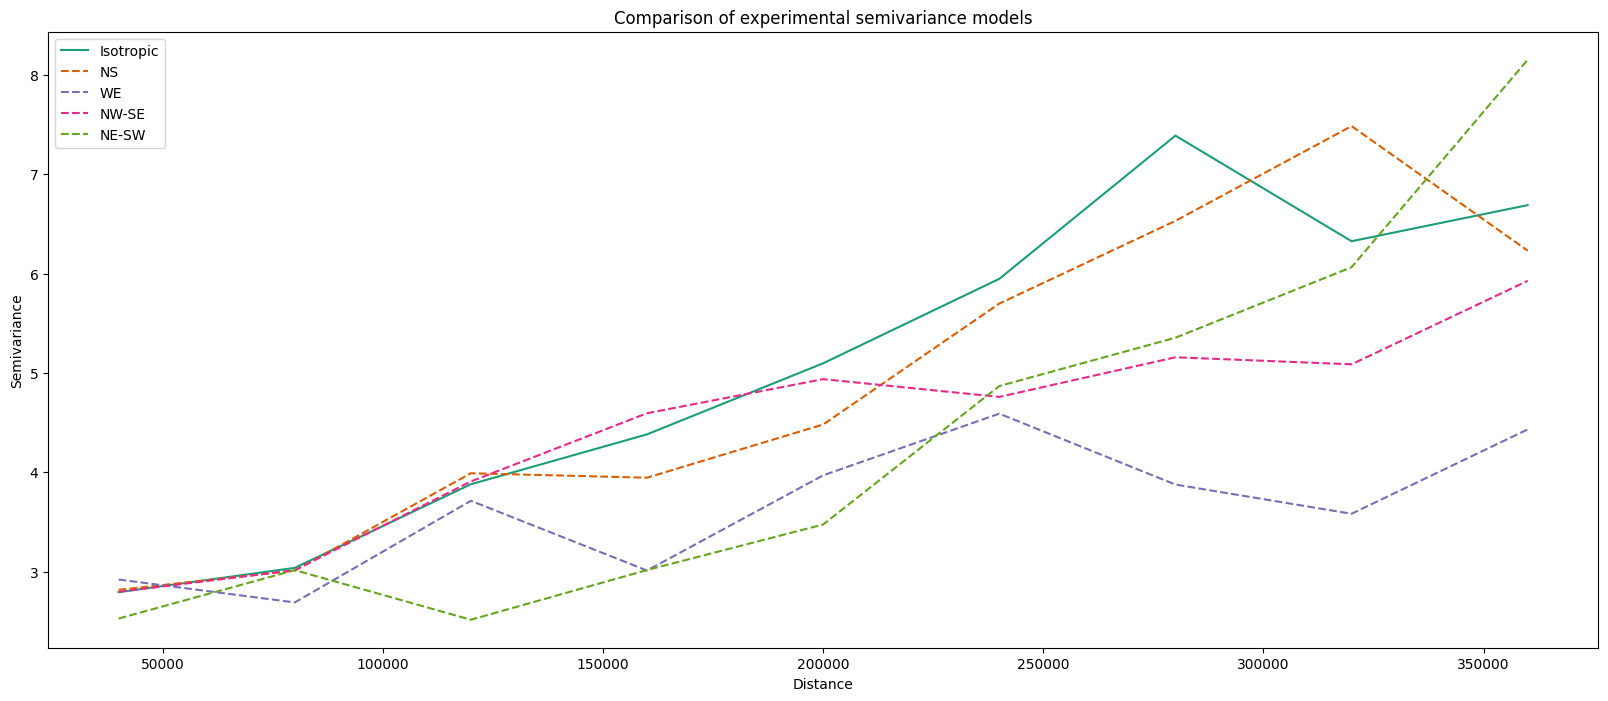

In [34]:
dir_var_e.show()

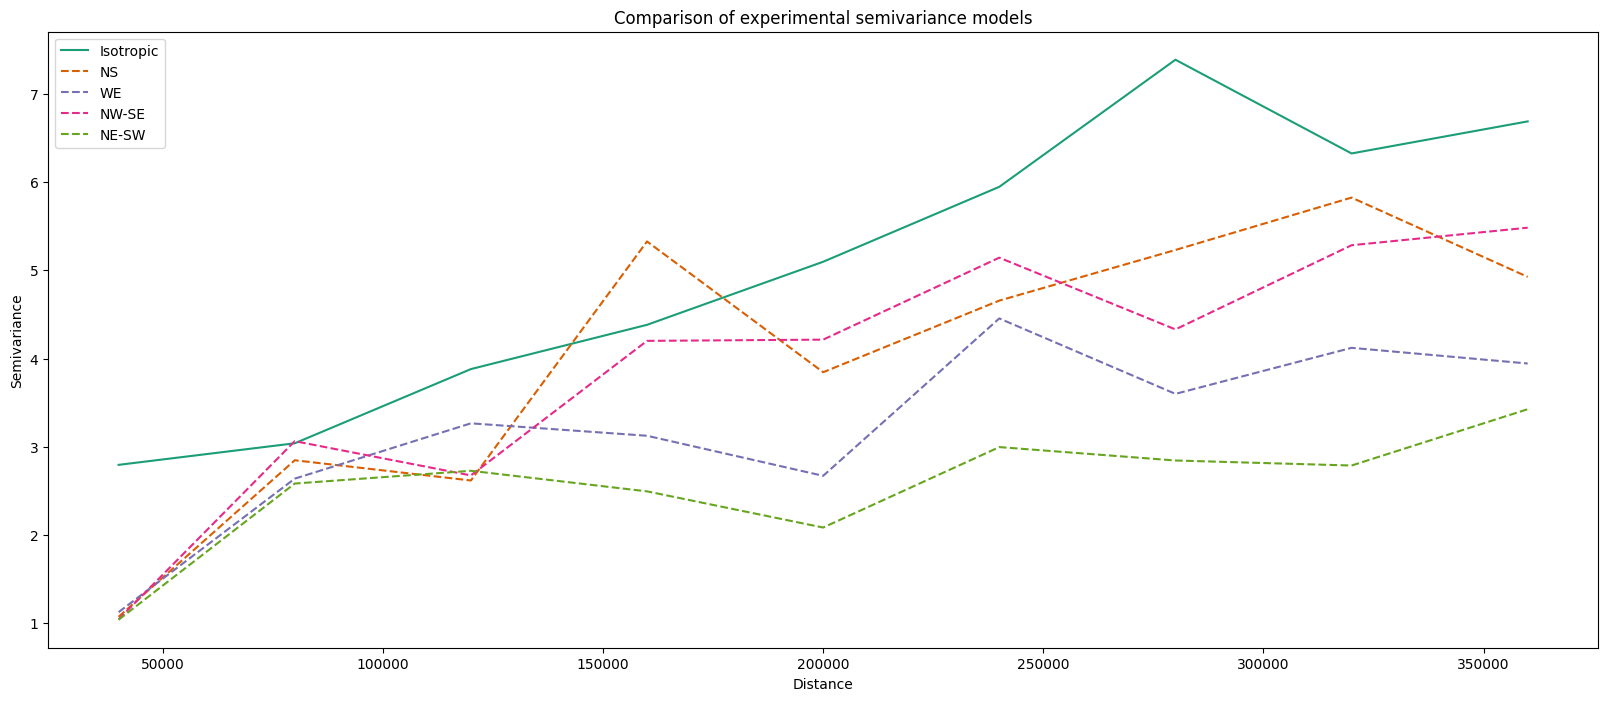

In [35]:
dir_var_t.show()

As you see, there are differences between neighbor selection methods. Areas in both methods are not equal, and in some cases one method may catch outliers that will change semivariance for a given lag significantly. Pick one method and use it consistently.

## Changelog

| Date       | Changes                                      | Author                           |
|------------|----------------------------------------------|----------------------------------|
| 2025-04-24 | Tutorial has been adapted to the 1.0 release | @SimonMolinsky (Szymon Moliński) |